Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

# I. Wrangle Data

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/class-project/LoanApproval/'

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder, OrdinalEncoder
from pandas_profiling import ProfileReport
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# 

In [3]:
ProfileReport(pd.DataFrame(pd.read_csv(DATA_PATH + 'train_data.csv')))


In [4]:
def wrangle(filepath):
    # Establish path to datafiles
    DATA_PATH = '../data/class-project/LoanApproval/'
    
    # Read in the data
    df = pd.read_csv(DATA_PATH + filepath)
    
    # Remove underscores in columns names (only used in 4 features/12 features)
    # for consistent formatting and increased ease of accessing features
    new_cols = [col.replace('_', '') for col in df.columns]
    df.columns = new_cols
    
    # Drop high-cardinality column, 'Loan_ID'
    threshold = 10 
    high_card_cols = [col for col in df.select_dtypes('object').columns
                     if df[col].nunique() > threshold]
    df.drop(high_card_cols, axis=1, inplace=True) 
      
    # Fill NaN values in 'LoanAmount' and 'LoanAmountTerm' columns = continuous variables 
    # will fill 'LoanAmount'with median value, will fill 'LoanAmountTerm' with the mode == max == 360 
    # Will impute remaining NaNs later with a strategy='most_frequent'
    
    df['LoanAmount'].fillna(value=df['LoanAmount'].median(), inplace=True)     
    df['LoanAmountTerm'].fillna(value=df['LoanAmountTerm'].mode()[0], inplace=True)
    
    
    # Convert 'Dependents' from strings to integers
    df['Dependents'] = df['Dependents'].str.replace('+', '')
    
    # Feature Engineering (No features are being built based on the target; should not be any leakage)
    # Applicant Income to LoanAmount
    df['ApplicantIncome2LoanAmount'] = (df['ApplicantIncome'] / df['LoanAmount']).round(2)
    
    # Total Income to LoanAmount
    df['TotalIncome2LoanAmount'] = ((df['ApplicantIncome'] + df['CoapplicantIncome']) /
                                    df['LoanAmount']).round(2)
    
    # Loan Amount to Loan_Amount_Term
    df['LoanAmount2LoanTerm'] = (df['LoanAmount'] / df['LoanAmountTerm']).round(2)
    
    # Convert 'CoapplicantIncome', 'LoanAmount', and 'LoanAmountTerm' to integers from floats
    for col in ['CoapplicantIncome', 'LoanAmount','LoanAmountTerm']:
        df[col] = df[col].astype(int)
    
    return df

train_path = 'train_data.csv'
train = wrangle(train_path)

In [5]:
train.head()


,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus,ApplicantIncome2LoanAmount,TotalIncome2LoanAmount,LoanAmount2LoanTerm
0,Male,No,0,Graduate,No,5849,0,128,360,1.0,Urban,Y,45.70,45.70,0.36
1,Male,Yes,1,Graduate,No,4583,1508,128,360,1.0,Rural,N,35.80,47.59,0.36
2,Male,Yes,0,Graduate,Yes,3000,0,66,360,1.0,Urban,Y,45.45,45.45,0.18
3,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1.0,Urban,Y,21.52,41.18,0.33
4,Male,No,0,Graduate,No,6000,0,141,360,1.0,Urban,Y,42.55,42.55,0.39


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Gender                      601 non-null    object 
 1   Married                     611 non-null    object 
 2   Dependents                  599 non-null    object 
 3   Education                   614 non-null    object 
 4   SelfEmployed                582 non-null    object 
 5   ApplicantIncome             614 non-null    int64  
 6   CoapplicantIncome           614 non-null    int64  
 7   LoanAmount                  614 non-null    int64  
 8   LoanAmountTerm              614 non-null    int64  
 9   CreditHistory               564 non-null    float64
 10  PropertyArea                614 non-null    object 
 11  LoanStatus                  614 non-null    object 
 12  ApplicantIncome2LoanAmount  614 non-null    float64
 13  TotalIncome2LoanAmount      614 non

In [7]:
# Change target 'Loan_Status' from Y/N to 1/0
# Can't be done in wrangle function, test data doesn't include a target
train['LoanStatus'].replace(to_replace={'Y': 1, 'N':0}, inplace=True)  

In [8]:
train.head(20)

,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus,ApplicantIncome2LoanAmount,TotalIncome2LoanAmount,LoanAmount2LoanTerm
0,Male,No,0,Graduate,No,5849,0,128,360,1.0,Urban,1,45.70,45.70,0.36
1,Male,Yes,1,Graduate,No,4583,1508,128,360,1.0,Rural,0,35.80,47.59,0.36
2,Male,Yes,0,Graduate,Yes,3000,0,66,360,1.0,Urban,1,45.45,45.45,0.18
3,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1.0,Urban,1,21.52,41.18,0.33
4,Male,No,0,Graduate,No,6000,0,141,360,1.0,Urban,1,42.55,42.55,0.39
5,Male,Yes,2,Graduate,Yes,5417,4196,267,360,1.0,Urban,1,20.29,36.00,0.74
6,Male,Yes,0,Not Graduate,No,2333,1516,95,360,1.0,Urban,1,24.56,40.52,0.26
7,Male,Yes,3,Graduate,No,3036,2504,158,360,0.0,Semiurban,0,19.22,35.06,0.44
8,Male,Yes,2,Graduate,No,4006,1526,168,360,1.0,Urban,1,23.85,32.93,0.47
9,Male,Yes,1,Graduate,No,12841,10968,349,360,1.0,Semiurban,0,36.79,68.22,0.97


In [9]:
# Examination of the 'Dependents' column shows string values

# train_df.replace({'Dependents': r'3+'}, {'Dependents': 3}, regex=True)
# train['Dependents'].replace(('+3', '3'), inplace=True)
# train['Dependents'].value_counts()
print(type(train.loc[1, 'Dependents']))
print(type(train.loc[7, 'Dependents']))
train['Dependents'].value_counts()

<class 'str'>
<class 'str'>


0    345
1    102
2    101
3     51
Name: Dependents, dtype: int64

In [10]:
# df['needs_to_repair'] = df['status_group'].apply(lambda x : 0 if x == 'functional' else 1)

# train['Dependents'] = train['Dependents'].apply(lambda x: x.replace('+', '') if x == '3+')
train['Dependents'] = train['Dependents'].str.replace('+', '')
train['Dependents'].astype(int)
train['Dependents'].value_counts()

ValueError: cannot convert float NaN to integer

In [11]:
# Plot some features

# II. Split the Data

In [12]:
# Data is divided into training and test data.  Will separate training into train/validation set. 
# Will use a random split; there is no datetime information included in this dataset.

In [13]:
# Target for this data set is 'Loan_Status'
# 'Loan Status is a binary feature (approved/not-approved) == CLASSIFICATION PROBLEM
 
# Split the Data into a Feature Matrix (FM) and Target Vector (TV)

target = 'LoanStatus'
y = train['LoanStatus']
X = train.drop(labels='LoanStatus', axis=1)

In [14]:
print(X.shape, y.shape)

(614, 14) (614,)


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish a Baseline

In [16]:
# Examine the distribution of the Target Vector - 'Loan_Status'
# It is a binary categorical variable - approved or not approved
# The classes of the Target Vector are moderately imbalanced towards approval
# Since this is a classification problem we will be looking at accuracy 
# You have a 69.65% chance of being correct if you always decide that the loan was approved; this is our baseline
# to beat

print(y_train.value_counts(normalize=True), "\n")
print('Baseline Accuracy: {:.4f}'.format(y_train.value_counts(normalize=True).max()))

1    0.696538
0    0.303462
Name: LoanStatus, dtype: float64 

Baseline Accuracy: 0.6965


In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 83 to 102
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Gender                      479 non-null    object 
 1   Married                     490 non-null    object 
 2   Dependents                  480 non-null    object 
 3   Education                   491 non-null    object 
 4   SelfEmployed                467 non-null    object 
 5   ApplicantIncome             491 non-null    int64  
 6   CoapplicantIncome           491 non-null    int64  
 7   LoanAmount                  491 non-null    int64  
 8   LoanAmountTerm              491 non-null    int64  
 9   CreditHistory               451 non-null    float64
 10  PropertyArea                491 non-null    object 
 11  ApplicantIncome2LoanAmount  491 non-null    float64
 12  TotalIncome2LoanAmount      491 non-null    float64
 13  LoanAmount2LoanTerm         491 no


# IV. Build Models

- `LogisticRegression`
    
    - `OneHotEncoder`
    - `SimpleImputer`
    - `StandardScaler`
 
- `RandomForrestClassifier`

    - `OrdinalEncoder`
    - `SimpleImputer`

In [18]:
# Model 1: Logistic Regression Model

model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Gender', 'Married', 'Dependents',
                                     'Education', 'SelfEmployed',
                                     'PropertyArea'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [19]:
# Model 2: Random Forest Classifier

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier(random_state=42)
)

model_rf.fit(X_train, y_train);

# V. Check Metrics

In [20]:
# Classification: Is your majority class frequency >= 50% and < 70% ? 
# If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. 
# What evaluation metric will you choose, in addition to or instead of accuracy?

# Our majority class is less than 70% and can just use accuracy.  Should, however, come back and build out a 
# confusion_matrix, and look at recall/precision.  Will also explore Precision, Recall, and F1 Score.

In [21]:
# Training and Validation accuracy of our Logistic Regression model

print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.8167006109979633
Validation Accuracy (LOGR): 0.7886178861788617


In [22]:
# Training and Validation accuarcy of our Random Forest model
# Model appears to be overfit

print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Valdiation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Valdiation Accuracy (RF): 0.7723577235772358


In [23]:
# Not very good precision for Y, great recall for Y

print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))

Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



In [24]:
# Not very good precision for Y, great recall for Y

print('Random Forest Classifier')
print(classification_report(y_val, model_rf.predict(X_val)))

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.76      0.51      0.61        43
           1       0.78      0.91      0.84        80

    accuracy                           0.77       123
   macro avg       0.77      0.71      0.73       123
weighted avg       0.77      0.77      0.76       123



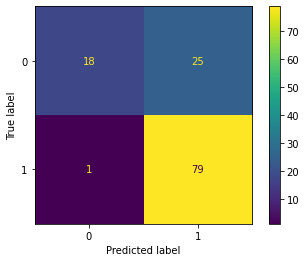

In [25]:
# Confusion Matrix for Logistic Regression

plot_confusion_matrix(model_lr, X_val, y_val, values_format='.0f')

## ROC Curve

- To evalute models for binary classification
- To decide what probability threshold you should use when making your predictions

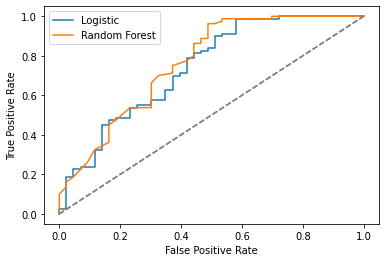

In [26]:
# Use VALIDATION DATA

# ROC curve is used with classification problems
# 'How far up can I go without having to go too far to the right?'
# An ROC curve let's you see how your model will perform at various thresholds
# Also allows you to compare different models 

lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rd = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Random Forest')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [27]:
print('Logistic: ROA-AUC Score:', roc_auc_score(y_val, model_lr.predict(X_val)))
print('Random Forest: ROC-AUC Score:', roc_auc_score(y_val, model_rf.predict(X_val)))


Logistic: ROA-AUC Score: 0.7030523255813954
Random Forest: ROC-AUC Score: 0.7120639534883721


# Tune the Model

In [28]:
params = {'randomforestclassifier__n_estimators': np.arange(20, 100, 5),
          'randomforestclassifier__max_depth': np.arange(10, 30, 5),
          'randomforestclassifier__max_samples': np.arange(0.1, 0.9, 0.2)}

rf_rs = RandomizedSearchCV(model_rf, param_distributions=params, n_iter=3, cv=5, n_jobs=-1, verbose=1)

In [29]:
rf_rs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.3s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['Gender',
                                                                   'Married',
                                                                   'Dependents',
                                                                   'Education',
                                                                   'SelfEmployed',
                                                                   'PropertyArea'],
                                                             mapping=[{'col': 'Gender',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': Male      1
NaN       2
Female    3
dtype: int64},
                                                                      {'col': 'Married',
                      

In [30]:
rf_rs.best_score_

0.8166151309008451

In [31]:
rf_rs.fit(X_val, y_val)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['Gender',
                                                                   'Married',
                                                                   'Dependents',
                                                                   'Education',
                                                                   'SelfEmployed',
                                                                   'PropertyArea'],
                                                             mapping=[{'col': 'Gender',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': Male      1
NaN       2
Female    3
dtype: int64},
                                                                      {'col': 'Married',
                      

In [32]:
rf_rs.best_score_

0.7326666666666667

In [33]:
# Let's try another model, and XGBClassifier
# STEP 1: Train model on whole dataset 

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=100,
                  random_state=42, 
                  n_jobs=-1)
)

model_xgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Gender', 'Married', 'Dependents',
                                      'Education', 'SelfEmployed',
                                      'PropertyArea'],
                                mapping=[{'col': 'Gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
NaN       2
Female    3
dtype: int64},
                                         {'col': 'Married',
                                          'data_type': dtype('O'),
                                          'mapping': Yes    1
No     2
NaN    3
dtype: int64},
                                         {'col': 'Dependents',
                                          'data_type': dtype('O'),
                                          'mapping': 0      1
2      2
3      3...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               imp

In [34]:
# STEP 2: Evaluate using the validation set
print('Training Accuracy', model_xgb.score(X_train, y_train))
print('Validation Accuracy', model_xgb.score(X_val, y_val))

Training Accuracy 1.0
Validation Accuracy 0.7560975609756098


In [35]:
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

Dependents                    0.025520
Gender                        0.028919
ApplicantIncome               0.036533
LoanAmount                    0.040385
Education                     0.042321
ApplicantIncome2LoanAmount    0.043340
LoanAmount2LoanTerm           0.044427
TotalIncome2LoanAmount        0.049218
SelfEmployed                  0.049546
PropertyArea                  0.049818
CoapplicantIncome             0.050232
Married                       0.066881
LoanAmountTerm                0.087620
CreditHistory                 0.385241
dtype: float32

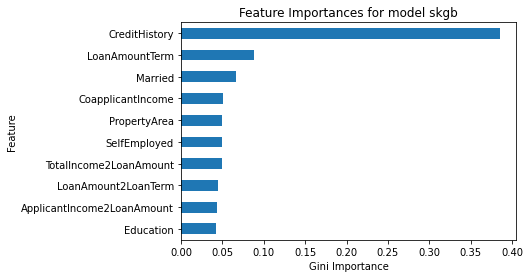

In [36]:
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for model skgb');

# When working with tree base models and feature importances, rather than regression models and their coefficients, 
# using feature importance (below) is one option, but we know it is misleading with high cardinality variables.

In [37]:
# STEP 3: Calculate performance metrics using permutated data (add static-noise to features)
perm_imp = permutation_importance(
    model_xgb,
    X_val, # Always use your VALIDATION set
    y_val,
    n_jobs=100,
    random_state=42
)

In [38]:
perm_imp.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [39]:
# Put results into a DataFrame
data = {'importances_mean': perm_imp['importances_mean'],
        'importances_std': perm_imp['importances_std']}
    
df = pd.DataFrame(data, index=X_val.columns)
df.sort_values(by='importances_mean', inplace=True)

In [40]:
df

,importances_mean,importances_std
LoanAmount2LoanTerm,-2.276423e-02,0.011949
LoanAmount,-2.113821e-02,0.008291
CoapplicantIncome,-1.138211e-02,0.011028
ApplicantIncome2LoanAmount,-1.138211e-02,0.008291
LoanAmountTerm,-6.504065e-03,0.003252
Gender,-3.252033e-03,0.006504
Married,-2.220446e-17,0.008906
Dependents,1.626016e-03,0.003252
Education,1.626016e-03,0.003252
SelfEmployed,1.626016e-03,0.003252


Text(0.5, 1.0, 'Permutation importance for model_xgb')

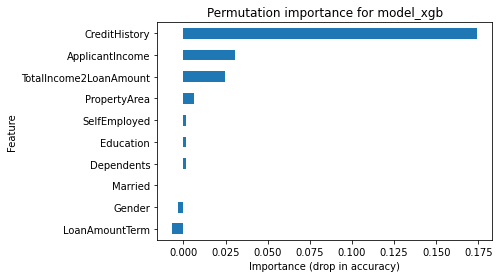

In [41]:
df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb')

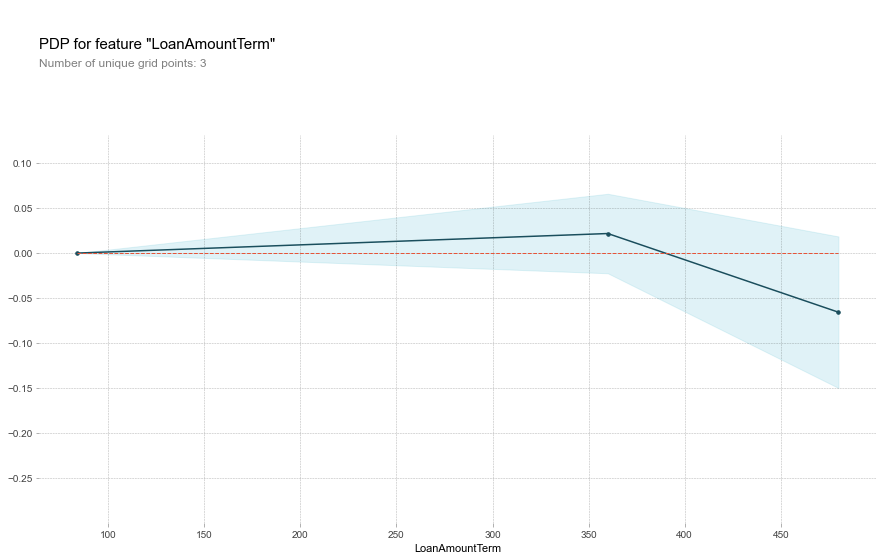

In [51]:
feature = 'LoanAmountTerm'

# Build your 'pdp_isolate' object 
# Create and instance of the pdp_isolate class
# Always use with test or validation data, NEVER training data
isolate = pdp_isolate(
    model=model_xgb,
    dataset=X_val, #<-- Always use with VALIDATION or TEST date
    model_features=X_val.columns,
    feature=feature
)

# Build your plot
pdp_plot(isolate, feature_name=feature);

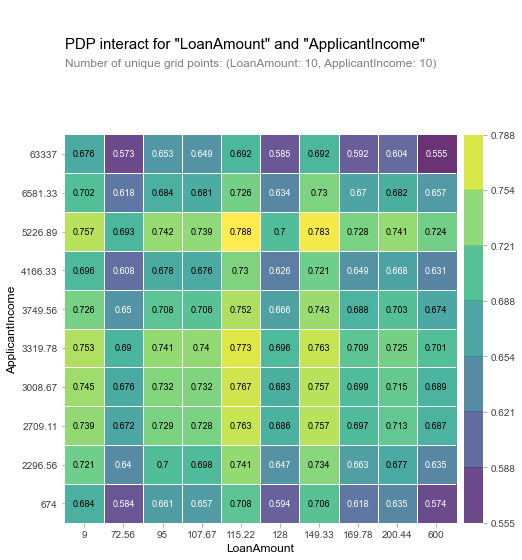

In [55]:
features = ['LoanAmount', 'ApplicantIncome']

interact = pdp_interact(
    model=model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);